# **APPLICATION OF CLUSTERING METHODS TO SPORULATION YEAST MICROARRAY DATA AGENDA**

## Lab 1 - Clustering applied to sporulation yeast data

**Author**: Diego De Pablo  
**Date**: October 2024

---

### **Introduction**

In this notebook, we will work on applying clustering methods to the sporulation yeast microarray data. The process will involve:

1. Initialize the libraries.
2. Reading the yeast data.
3. Preprocessing and preparing the data for clustering.
4. Visualizing Gene Expression Data with Seaborn
5. Application of K-means algorithm.
6. Analysis with PCA.
7. Visualization of clusters and centroids.
8. Silhouette analysis
9. Applying hierarchical clustering (HC), self-organizing maps (SOM) and Other Possible Implementations
10. Validation

The main goal is to group genes into clusters that might reflect different stages of the sporulation process in yeast, allowing us to gain biological insights.

### **Initialize the libraries**
As usual in Python, we work with various libraries. As usual, all libraries will be initialized from the beginning, making it easier to execute third-party code by knowing which libraries will need to be installed to run the script.

In [1]:
# Manejo de datos
import numpy as np
import pandas as pd

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Preprocesamiento y clustering
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score, silhouette_samples
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.ndimage import label

# Mapas Auto-Organizados
try:
    from minisom import MiniSom
except ImportError:
    !pip install minisom
    from minisom import MiniSom


  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.3-py3-none-any.whl size=11706 sha256=7df3b1fbe24be88d4c9a0bbe82d0a945a8882f5f71dbd9e2d776319d642f1afb
  Stored in directory: /root/.cache/pip/wheels/96/98/a5/52dee3e8ed1dbfc4d77e4da41b6d89dd7ab9ead1b921e766f8
Successfully built minisom


### **Reading the yeast data.**

In this step, we will load the dataset using pandas and check the basic structure of the data, including the number of rows (samples) and columns (variables).

The dataset is available in my github repository along with 5 study materials ([you can enter my repository by clicking here ](https://github.com/Diegodepab/clustering_genes/tree/main/dataset))


In [2]:
data = pd.read_csv('/content/sporulation-filtered.txt', sep='\t')

print(data.head(2))
print(data.tail(1))

rows, columns = data.shape
print(f"This data frame has {rows} rows (samples) and {columns} columns (variables)")

     Genes        t0       t0,5         t2         t5         t7        t9  \
0  YAL025C  1,163781  -1,758143   -0,31495   0,283874    -0,6779  0,470183   
1  YAL036C  0,955552   -1,48956  -0,499057  -0,099143  -0,674453  1,414381   

      t11,5  
0  0,833156  
1   0,39228  
       Genes        t0       t0,5        t2         t5         t7         t9  \
473  YPL198W  1,552631  -0,019515  -0,39212  -1,218152  -0,896972  -0,092712   

       t11,5  
473  1,06684  
This data frame has 474 rows (samples) and 8 columns (variables)


We can see how the first column (Genes variable) is a unique identifier, when applying artificial intelligence algorithm it is better to get rid of them.

### **Preprocessing and Preparing the Data for Clustering**

In this section, we perform several critical steps for preparing the dataset for further analysis:

1. **Missing Values**:
   - We identify and count missing values per column and determine how many rows are affected.
   - The percentage of rows with missing data is calculated to assess the impact of imputation. If the percentage of affected rows is less than 1%, we drop those rows to maintain data integrity. If it's greater than 1%, we proceed with mean imputation.
   - It is important to ensure that the percentage of imputed data is not large, as this can affect the reliability of our results.

2. **Imputation**:
   - When necessary, missing values are filled using mean imputation. While this helps maintain the dataset, excessive imputation (over 10%) can introduce bias and skew the results.

3. **Standardization**:
   - We scale the numeric data to ensure all features are on the same scale, which is critical for distance-based algorithms like k-means.

---

Preprocessing ensures that missing values are properly handled and features are comparable in scale. Monitoring the proportion of missing data is essential, as excessive imputation can distort results and compromise the integrity of clustering analyses.


In [3]:
# Reemplazamos las comas por puntos en todas las columnas excepto 'Genes'
data_numeric = data.drop(columns=['Genes']).replace(',', '.', regex=True)

# Convertimos las columnas numéricas a tipo float
data_numeric = data_numeric.apply(pd.to_numeric)

# Comprobamos si hay valores faltantes en el dataset
missing_values = data_numeric.isnull().sum()
total_missing = missing_values.sum()
total_rows = data_numeric.shape[0]


# Mostrar cuántos valores faltan por columna
if total_missing > 0:
    print("Missing values per column:\n", missing_values[missing_values > 0], "\n")

    # Contamos cuántas filas tienen al menos un valor faltante
    rows_with_missing = data_numeric.isnull().any(axis=1).sum()
    percentage_missing = (rows_with_missing / total_rows) * 100
    print(f"Number of rows affected by missing values: {rows_with_missing}")
    print(f"Percentage of rows affected by missing values: {percentage_missing:.2f}% ", "\n")

    # Decidir entre eliminar o imputar datos
    if percentage_missing < 1.0:
        print("Less than 1% of rows have missing values. Dropping affected rows.", "\n")
        data_numeric = data_numeric.dropna()
    else:
        print("More than 1% of rows have missing values. Proceeding with imputation.", "\n")
        imputer = SimpleImputer(strategy='mean')
        data_numeric = imputer.fit_transform(data_numeric)
        data_numeric = pd.DataFrame(data_numeric, columns=data_numeric.columns)
else:
    print("No missing values found.")
    # Si no hay valores faltantes, copiamos el dataset original
    data_numeric = data_numeric.copy()

# Combinamos la columna 'Genes' de vuelta al dataset
data_imputed = pd.concat([data['Genes'], data_numeric], axis=1)


# Estandarización de los datos (solo las columnas numéricas)
scaler = StandardScaler()
scaled_data_numeric = scaler.fit_transform(data_numeric)

# Convertimos a DataFrame y podríamos añadir de nuevo la columna 'Genes'
scaled_data = pd.DataFrame(scaled_data_numeric, columns=data_numeric.columns)
#scaled_data_genes = pd.concat([data['Genes'], scaled_data], axis=1)

# Mostramos las primeras filas del dataset escalado
print("Scaled data (without Genes):")
print(scaled_data.head(3))


No missing values found.
Scaled data (without Genes):
         t0      t0,5        t2        t5        t7        t9     t11,5
0  0.775046 -1.495766  0.001133  0.587191 -1.026146  0.306113  0.543629
1  0.637444 -1.158672 -0.309585 -0.094853 -1.022190  1.825686 -0.066974
2  0.967225 -0.211825  0.408457 -1.020384 -1.154436  1.788873 -1.481093


Something important to note is to evaluate the original dataset no matter how good it looks initially, in my case I applied the function without reviewing the entire dataset and The analysis identified a total of 2 missing values ​​in the `t11,5` column, representing approximately 0.42% of the total rows. Since this percentage is below the established 1% threshold, the affected rows were dropped instead of imputing values. Later I reviewed the original dataset and it turns out that at the end of the document there were 2 rows that gave the mean and the std of the 474 genes, these 2 rows compromise the honesty of the data, and it is precisely these that this algorithm detected as missing t11,5.

Subsequently, the dataset was standardized to ensure all features are on the same scale for further clustering analysis.

### **Visualizing Gene Expression Data with Seaborn**

In this section, we utilize Seaborn's pair plot functionality to visualize the relationships between the different time points of gene expression in our dataset.
- **Multi-dimensional Visualization**: It allows us to explore the relationships between multiple features simultaneously, making it easier to identify potential clusters or patterns in the data.
- **Distribution Insight**: The histograms on the diagonal offer insights into the distribution of each variable, helping us assess if any transformations or additional preprocessing might be needed.



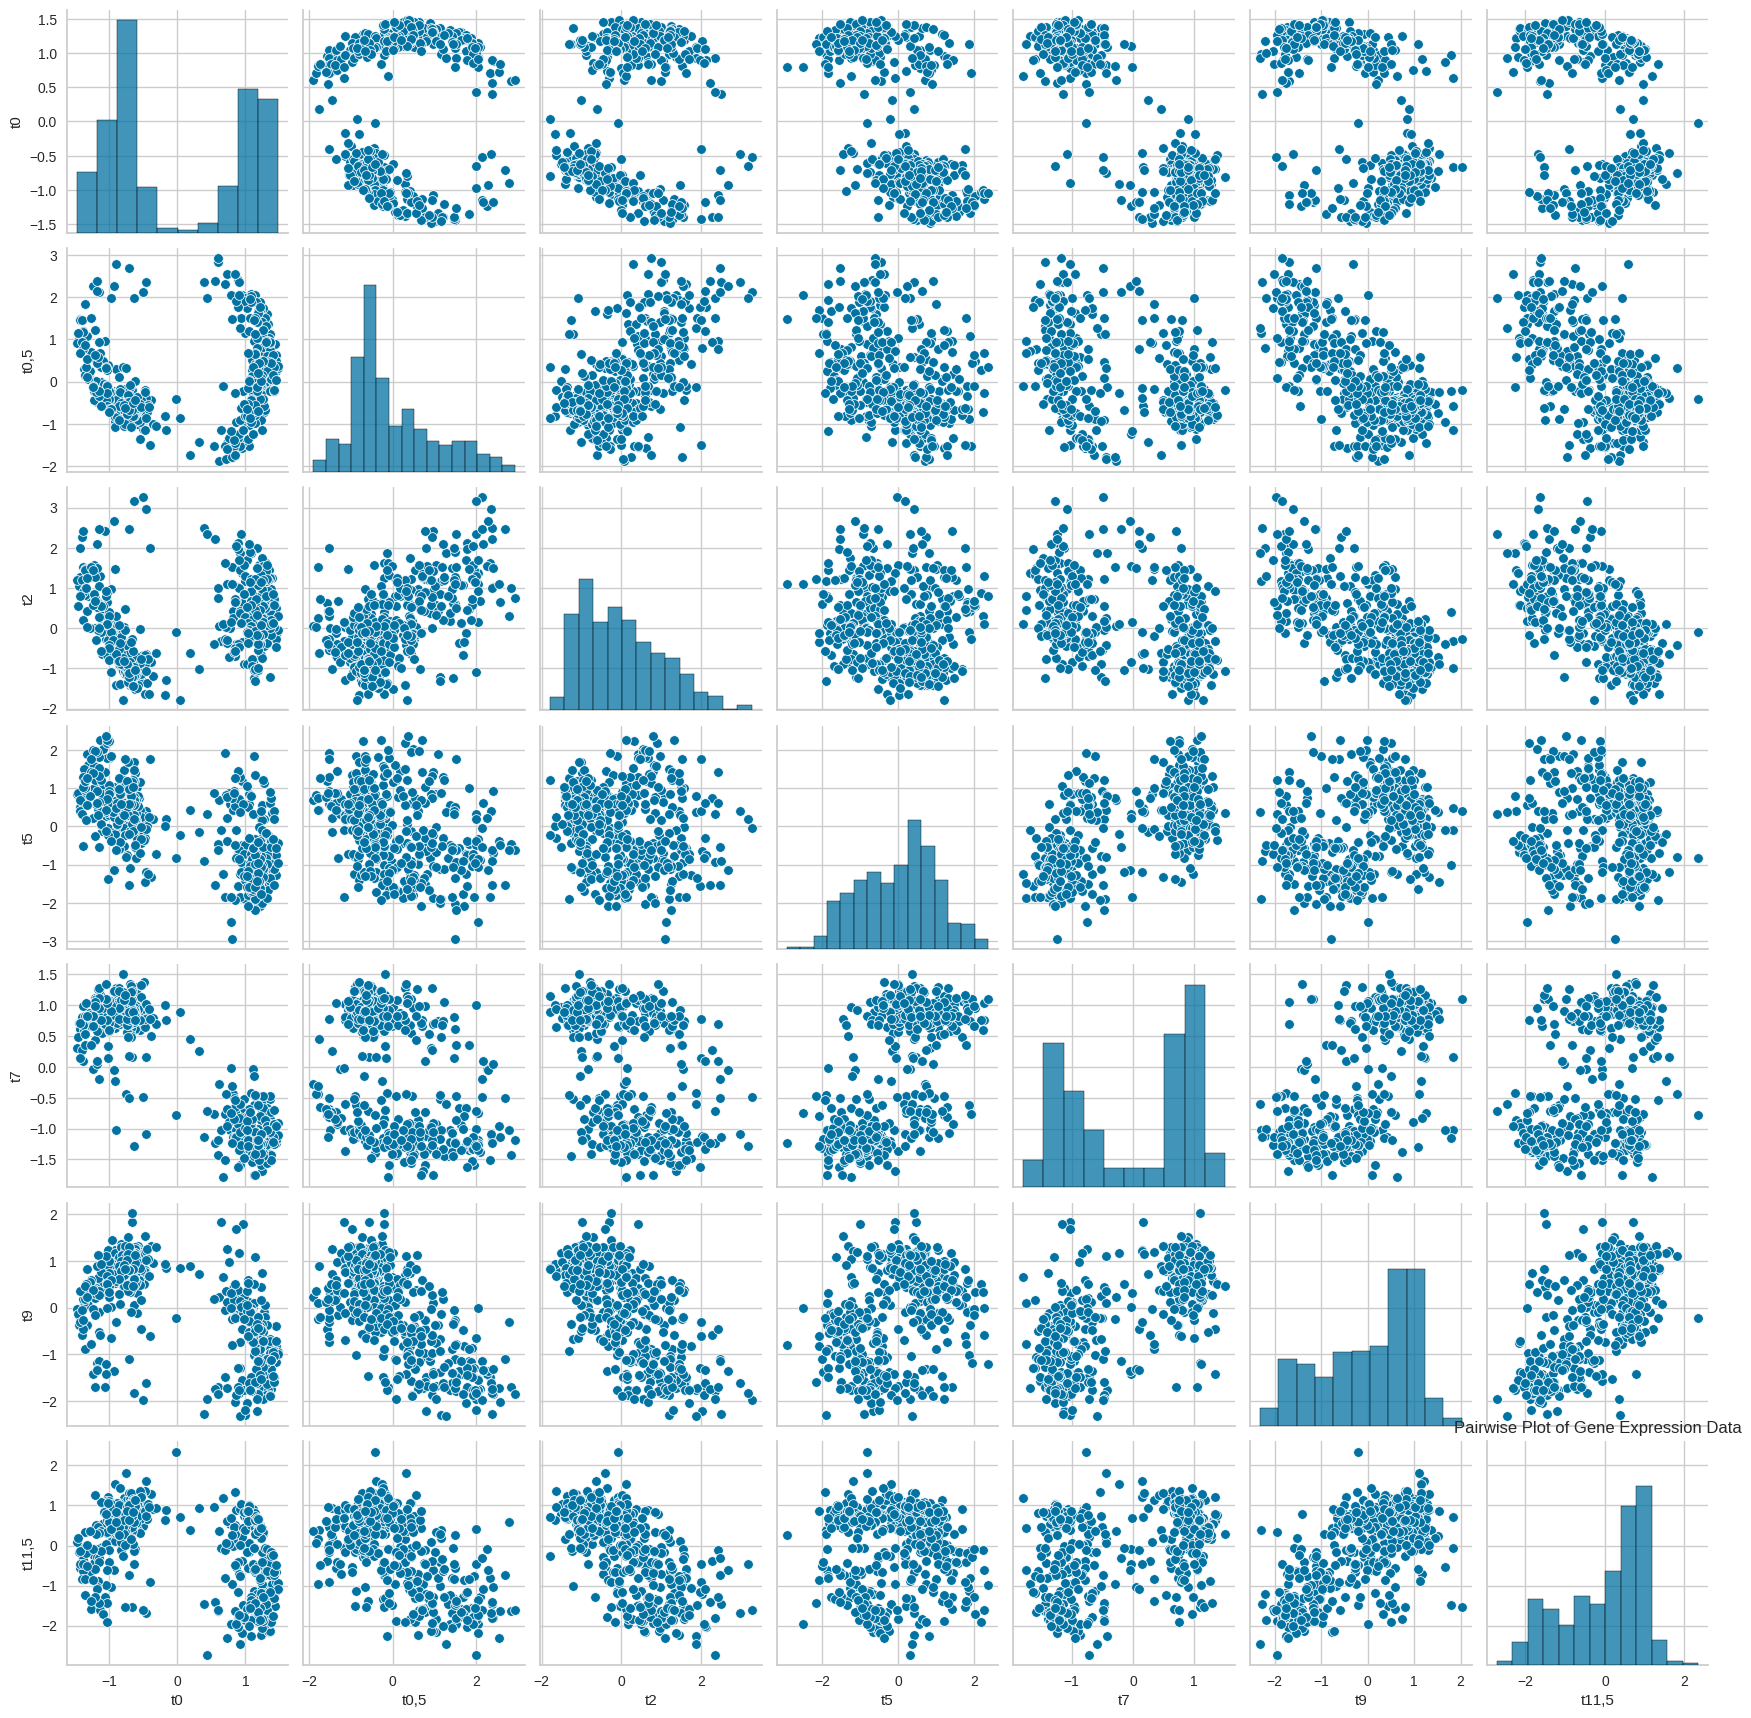

In [4]:
# Assuming 'scaled_data' is your DataFrame without the 'Genes' column
sns.pairplot(scaled_data)
plt.title("Pairwise Plot of Gene Expression Data")
plt.show()


 **Interpreting the Pair Plot:**
- **Diagonal Histograms**: On this occasion we can see how the standardization was a good success when seeing how clean the histograms look without anomalous points or an extremely wide distribution.

- **Scatter Plots**: The scatter plots displayed in the lower and upper triangles illustrate the relationships between pairs of features. Potential clusters may manifest as distinct groupings of points, which can suggest correlations or interactions between the variables.

- **Look for Patterns**: It can be observed that when relating the variables T0 with the other variables, they behave in a similar way. This may be due to the fact that T0 has a strong influence on the other variables or the existence of a hidden pattern. This will be interesting to see later.



### **Application of K-means algorithm**

Clustering is an unsupervised machine learning technique used to divide a dataset into distinct groups or clusters. Each cluster consists of data points that are more similar to each other than to those in other clusters. KMeans is a popular clustering algorithm that partitions data into a predefined number of clusters, represented by centroids. The algorithm works iteratively to assign data points to the nearest centroid, updating centroids based on the mean of the points assigned to each cluster.

Beyond the scikit-learn library, determining the optimal number of clusters (K) is crucial in clustering. Several methods exist for this selection.

#### **Elbow Method in KMeans Clustering**
The Elbow Method is a heuristic used to determine the optimal number of clusters (k) for the KMeans algorithm. It evaluates the inertia (or within-cluster sum of squares), which measures how compact the clusters are by calculating the squared distances between data points and their respective cluster centroids.

As k increases, inertia naturally decreases, since more clusters reduce the distance between points and centroids. However, after a certain point, adding more clusters offers diminishing returns in terms of clustering quality. The Elbow Point is where the inertia starts to level off, creating a visible "elbow" shape in the plot. This point indicates the optimal balance between the number of clusters and the clustering performance.


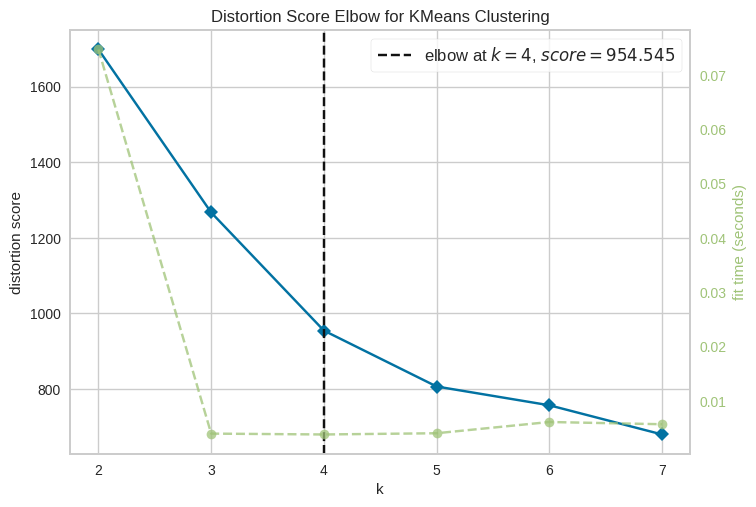

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [5]:
# Inicializamos el algoritmo KMeans
kmeans = KMeans()

# Creamos un visualizador para el método del codo
elbow_visualizer = KElbowVisualizer(kmeans, k=(2, 8))

# Ajustamos el visualizador a los datos escalados
elbow_visualizer.fit(scaled_data)

# Mostramos la gráfica del codo
elbow_visualizer.show()


The method calculates inertia for different values of k (in this case, from 2 to 8).
The inertia decreases as more clusters are added, but the rate of decrease slows down after a certain point.
The optimal number of clusters is often found at the "elbow" of the plot, where further increasing k yields little improvement in reducing inertia. In this case the best selection is k=4

However, this method does not always guarantee the best number of clusters in terms of cluster quality. The elbow method is based solely on inertia, which measures how cohesive the points are within their clusters, but it does not take into account the separation between clusters or other deeper aspects of clustering quality, so it is interesting to create a function that takes the metrics we want to prioritize for this work.


#### **evaluate_kmeans_clustering (validation)**

In the next section of the code, we will apply the KMeans algorithm to our dataset to determine the optimal number of clusters. To evaluate the clustering performance, we will use two key metrics:

*  **Inertia:** like elbow method, this measures how tightly the data points are grouped around their centroids. A lower inertia value indicates better clustering performance. However, inertia alone cannot determine the optimal number of clusters since it tends to decrease with an increasing number of clusters.
*  **Silhouette Score:** This evaluates the cohesion and separation of clusters. It ranges from -1 to 1, where a higher score indicates that the points are well-matched within their clusters and poorly matched to neighboring clusters. with this we can determining the number of clusters that yields the best balance between intra-cluster similarity and inter-cluster separation.
* **Calinski-Harabasz Index:** This index measures the quality of clustering by comparing the dispersion between clusters to the dispersion within clusters. It is calculated as the ratio of the variance between clusters to the variance within clusters. A higher value indicates better clustering, as it suggests that clusters are well separated and compact. This index is useful for determining the optimal number of clusters, as it tends to increase with the number of clusters until it reaches a maximum.
* **Davies-Bouldin Index:** This index assesses the quality of clustering by measuring the ratio of the separation to the compactness of clusters. It is calculated as the average of the ratios of the sum of the distances within each cluster to the distance between the nearest clusters. A lower value of the Davies-Bouldin index indicates better clustering, as it suggests that clusters are well separated and compact. Unlike the Calinski-Harabasz index, a low value is desirable for this index.
* **Average Proportion of Non-Overlap Measure (V1):** This measure calculates the average proportion of genes that are not placed in the same cluster when comparing the clustering performed using the full dataset with the clustering performed after removing one time point. The smaller this value, the higher the consistency of the clustering algorithm.



We will visualize the Silhouette Scores for different values of k (number of clusters), which will help us assess the optimal number of clusters for our data. The plot will provide a graphical representation of how well-separated and coherent the clusters are, making it easier to interpret which k offers the best performance.

K=2: Inertia=1698.9538210274006, Silhouette Score=0.4590519903668428, Calinski-Harabasz Index=449.8002164725946, Davies-Bouldin Index=0.9423108004411757, V1 Score=0.03556359252561784
K=3: Inertia=1267.30397827706, Silhouette Score=0.42178724447119087, Calinski-Harabasz Index=381.0758282099951, Davies-Bouldin Index=1.0592257694741656, V1 Score=0.22212176009644363
K=4: Inertia=954.5450321993009, Silhouette Score=0.4354151052075155, Calinski-Harabasz Index=387.9069076175337, Davies-Bouldin Index=0.9506783898812347, V1 Score=0.35563592525617843
K=5: Inertia=880.1895098222232, Silhouette Score=0.38448091362022063, Calinski-Harabasz Index=324.7406118610477, Davies-Bouldin Index=1.2571561888048193, V1 Score=0.3336347197106691
K=6: Inertia=731.304610700466, Silhouette Score=0.41208178091066644, Calinski-Harabasz Index=331.0722849217801, Davies-Bouldin Index=1.0953896744789813, V1 Score=0.324291742013261
K=7: Inertia=681.6688144878822, Silhouette Score=0.411513998143558, Calinski-Harabasz Index

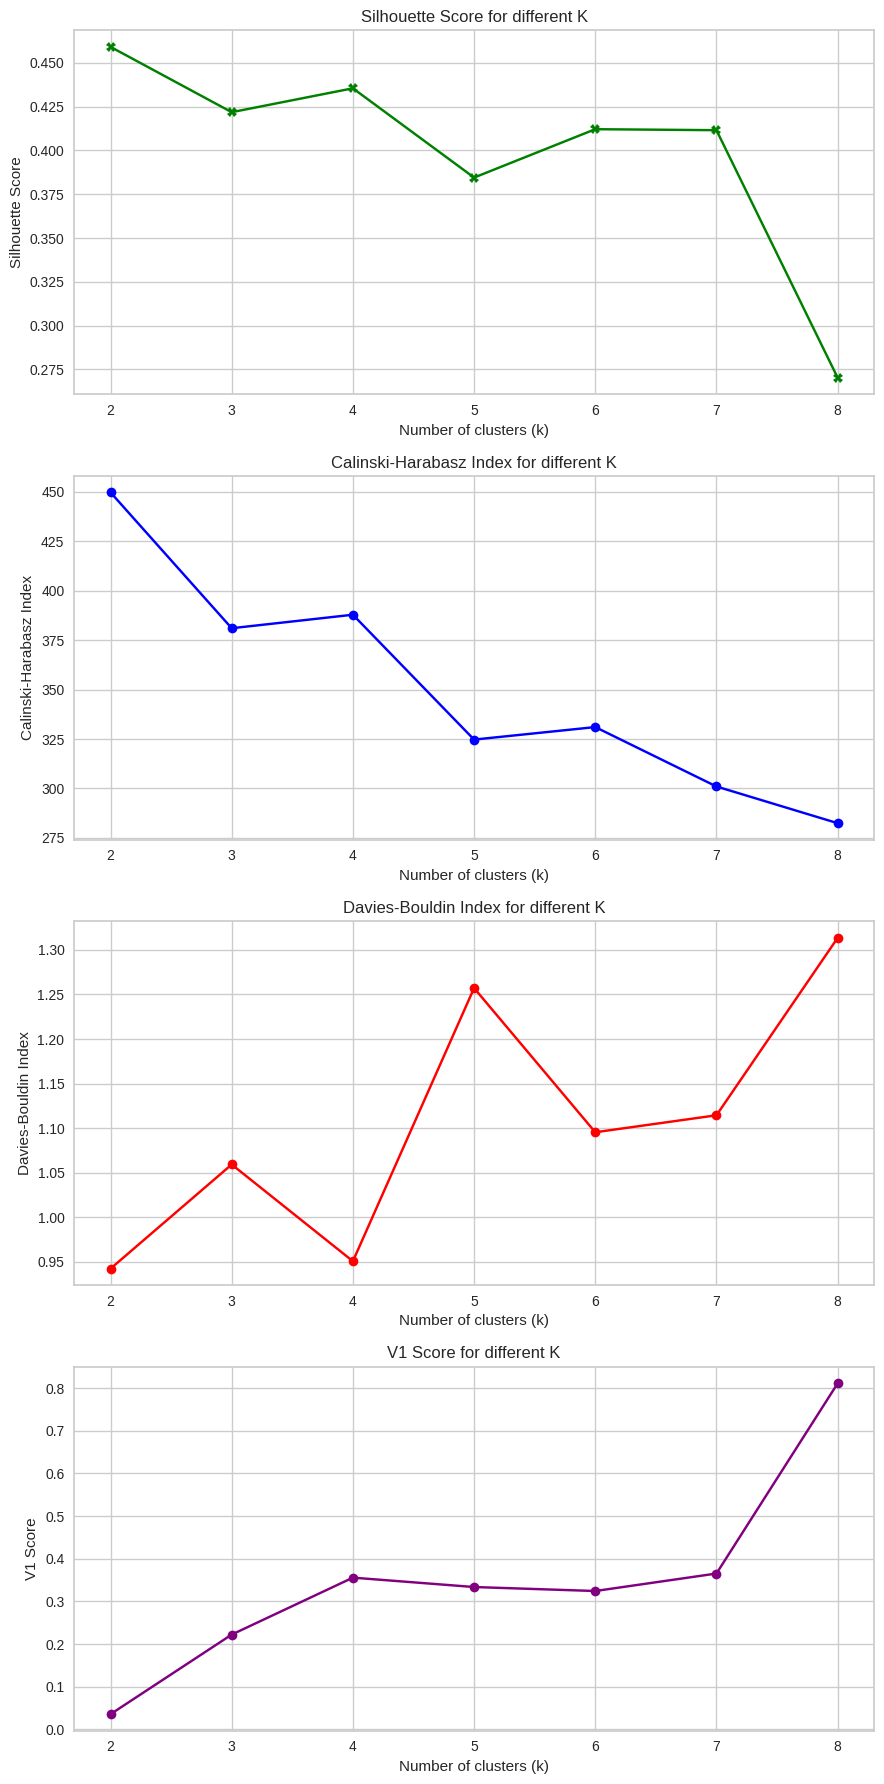

In [6]:
def compute_v1(data, k):
    n_genes, n_time_points = data.shape
    M = n_time_points  # Número de puntos temporales
    V1_score = 0

    # Agrupamiento completo (con todos los puntos temporales)
    kmeans_full = KMeans(n_clusters=k, random_state=42)
    kmeans_full.fit(data)
    labels_full = kmeans_full.labels_

    # Eliminar un punto temporal cada vez
    for t in range(n_time_points):
        data_without_t = np.delete(data, t, axis=1)
        kmeans_partial = KMeans(n_clusters=k, random_state=42)
        kmeans_partial.fit(data_without_t)
        labels_partial = kmeans_partial.labels_

        # Cálculo de la proporción de no coincidencia
        for g in range(n_genes):
            if labels_partial[g] != labels_full[g]:
                V1_score += 1

    V1_score = V1_score / (M * n_genes)
    return V1_score

from sklearn.metrics import pairwise_distances

def calculate_v2_kmeans(data, clusters):
    num_clusters = len(np.unique(clusters))
    original_means = []

    # Calcular perfiles medios originales
    for c in range(num_clusters):
        cluster_data = data[clusters == c]
        original_means.append(cluster_data.mean(axis=0))

    original_means = np.array(original_means)

    v2_sum = 0
    num_timepoints = data.shape[1]  # Suponiendo que cada columna es un punto de tiempo

    for timepoint in range(num_timepoints):
        # Eliminar el tiempo actual
        modified_data = np.delete(data, timepoint, axis=1)

        # Recalcular clústeres
        new_clusters = KMeans(n_clusters=num_clusters).fit_predict(modified_data)

        # Calcular nuevos perfiles medios
        new_means = []
        for c in range(num_clusters):
            cluster_data = modified_data[new_clusters == c]
            new_means.append(cluster_data.mean(axis=0))

        new_means = np.array(new_means)

        # Calcular distancias y sumarlas
        distances = pairwise_distances(original_means, new_means)
        v2_sum += np.mean(distances)

    v2_final = v2_sum / num_timepoints
    return v2_final

def evaluate_kmeans_clustering(data, min_k=2, max_k=10):
    metrics_kmers = {}  # Diccionario para almacenar los resultados de las métricas
    silhouette_scores = []
    inertias = []
    calinski_harabasz_scores = []
    davies_bouldin_scores = []
    v1_scores = []  # Para almacenar los puntajes V1
    k_values = range(min_k, max_k + 1)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)

        # Inertia (within-cluster sum of squares)
        inertia = kmeans.inertia_
        inertias.append(inertia)

        # Silhouette Score
        silhouette_avg = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)

        # Calinski-Harabasz Index
        calinski_harabasz = calinski_harabasz_score(data, kmeans.labels_)
        calinski_harabasz_scores.append(calinski_harabasz)

        # Davies-Bouldin Index
        davies_bouldin = davies_bouldin_score(data, kmeans.labels_)
        davies_bouldin_scores.append(davies_bouldin)

        # Calcular la métrica V1
        v1_score = compute_v1(data, k)
        v1_scores.append(v1_score)

        # Almacenar resultados en el diccionario
        metrics_kmers[k] = {
            'Inertia': inertia,
            'Silhouette Score': silhouette_avg,
            'Calinski-Harabasz Index': calinski_harabasz,
            'Davies-Bouldin Index': davies_bouldin,
            'V1 Score': v1_score
        }

        print(f"K={k}: Inertia={inertia}, Silhouette Score={silhouette_avg}, "
              f"Calinski-Harabasz Index={calinski_harabasz}, Davies-Bouldin Index={davies_bouldin}, V1 Score={v1_score}")

    # Plotting the metrics for each k
    plt.figure(figsize=(9, 18))

    # Silhouette Score plot
    plt.subplot(4, 1, 1)
    plt.plot(k_values, silhouette_scores, 'X-', color='green')
    plt.title("Silhouette Score for different K")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.grid(True)

    # Calinski-Harabasz Index plot
    plt.subplot(4, 1, 2)
    plt.plot(k_values, calinski_harabasz_scores, 'o-', color='blue')
    plt.title("Calinski-Harabasz Index for different K")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Calinski-Harabasz Index")
    plt.grid(True)

    # Davies-Bouldin Index plot
    plt.subplot(4, 1, 3)
    plt.plot(k_values, davies_bouldin_scores, 'o-', color='red')
    plt.title("Davies-Bouldin Index for different K")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Davies-Bouldin Index")
    plt.grid(True)

    # V1 Score plot
    plt.subplot(4, 1, 4)
    plt.plot(k_values, v1_scores, 'o-', color='purple')
    plt.title("V1 Score for different K")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("V1 Score")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return metrics_kmers


# Llama a la función con tus datos escalados
metrics_kmers = evaluate_kmeans_clustering(scaled_data, min_k=2, max_k=8)

The Scores plot for different cluster numbers reveals several important insights:
* **K = 2**
  * **Inertia:** 1698.95 (high)
  * **Silhouette Score:** 0.459 (highest)
  * **Calinski-Harabasz Index:** 449.80 (high)
  * **Davies-Bouldin Index:** 0.942 (low)
  * **Summary:** Excellent separation and cohesion, best overall performance.
  * **V1 Score:** 0.0356 (very low, Indicates a high level of stability in clustering, suggesting that the clusters remain consistent even when one time point is removed.)


* **K = 3**
  * **Inertia:** 1267.30 (lower)
  * **Silhouette Score:** 0.422 (decreased)
  * **Calinski-Harabasz Index:** 381.08 (decreased)
  * **Davies-Bouldin Index:** 1.059 (increased)
  * **Summary:** Decreased separation and cohesion compared to K = 2.
  * **V1 Score:** 0.2221 (moderate)

* **K = 4**
  * **Inertia:** 954.55 (lower)
  * **Silhouette Score:** 0.435 (slightly improved)
  * **Calinski-Harabasz Index:** 387.91 (slightly improved)
  * **Davies-Bouldin Index:** 0.951 (improved)
  * **Summary:** Improved clustering compared to K = 3, but not as good as K = 2.
  * **V1 Score:** 0.3556 (moderate)

* **K = 5**
  * **Inertia:** 880.19 (lower)
  * **Silhouette Score:** 0.384 (significantly decreased)
  * **Calinski-Harabasz Index:** 324.74 (decreased)
  * **Davies-Bouldin Index:** 1.257 (high)
  * **Summary:** Deteriorating clustering quality.
  * **V1 Score:** 0.33363 (moderate)

* **K = 6**
  * **Inertia:** 731.30 (lower)
  * **Silhouette Score:** 0.412 (slightly improved)
  * **Calinski-Harabasz Index:** 331.07 (slightly improved)
  * **Davies-Bouldin Index:** 1.095 (high)
  * **Summary:** Improved clustering compared to K = 5, but still poor compared to K = 2 and K = 4.
  * **V1 Score:** 0.3243 (moderate)

* **General Conclusions:**
  * K = 2 is the optimal choice, offering the best separation and cohesion.
  * K = 4 is a reasonable alternative, but it doesn't outperform K = 2.
  * Larger values of K lead to decreased clustering quality.

Based on the Silhouette Score, K=2 emerges as the optimal number of clusters, exhibiting the highest score and a well-defined clustering structure. The elbow method also suggests K=4 as a potential candidate, striking a balance between inertia (954.54) and a reasonably high Silhouette Score (0.435).








### **Analysis with PCA**
Dimensionality reduction with Principal Component Analysis (PCA) is a statistical technique that transforms a set of possibly correlated variables into a set of uncorrelated values ​​called principal components.

In simple terms, [PCA](http://staff.ustc.edu.cn/~zwp/teach/MVA/abdi-awPCA2010.pdf) does the following:

1. **Calculate:** Compute the covariance matrix of the data.
2. **Extract:** Determine the eigenvalues and eigenvectors of the covariance matrix.
3. **Select:** Choose the principal components with the highest eigenvalues.
4. **Project:** Project the original data onto the selected principal components.


Applying PCA reduces noise and model complexity, as well as allowing for clearer visualization by reducing the number of dimensions. However, PCA has certain limitations, such as the loss of information due to the reduction in dimensions and the difficulty in interpreting the results, since the principal components are linear combinations of the original variables.


#### **PCA with 2 components and k=2**


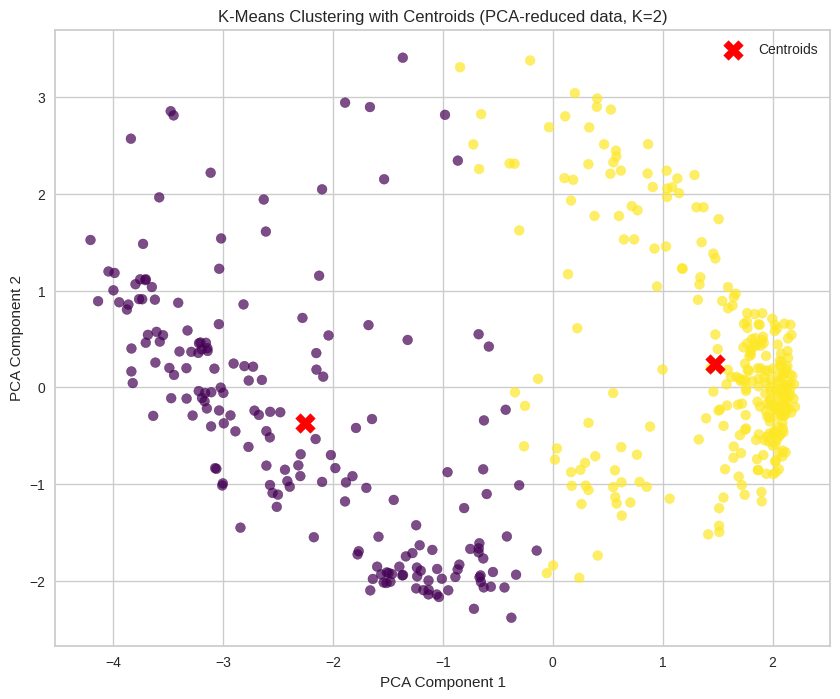

In [7]:

def generate_colors(n):
    # Generar una lista de colores usando una colormap de matplotlib
    return plt.cm.viridis(np.linspace(0, 1, n))

def visualize_kmeans_with_pca(scaled_data, n_clusters=2):
    # Asegúrate de que scaled_data es un DataFrame
    if isinstance(scaled_data, pd.DataFrame):
        scaled_data = scaled_data.values  # Convertir a matriz NumPy

    # Reducción de dimensionalidad con PCA
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(scaled_data)

    # Aplicar KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=69)
    clusters = kmeans.fit_predict(scaled_data)

    # Generar colores
    colors = generate_colors(n_clusters)

    # Crear un scatter plot con los clusters
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=[colors[cluster] for cluster in clusters], s=50, alpha=0.7)

    # Añadir los centroides al gráfico
    centroids = kmeans.cluster_centers_
    centroids_pca = pca.transform(centroids)  # Transformar los centroides a las dimensiones de PCA
    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, marker='X', label='Centroids')

    # Etiquetas y título
    plt.title(f'K-Means Clustering with Centroids (PCA-reduced data, K={n_clusters})')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()

def plot_silhouette(scaled_data, n_clusters):
    # Asegúrate de que scaled_data es un DataFrame
    if isinstance(scaled_data, pd.DataFrame):
        scaled_data = scaled_data.values  # Convertir a matriz NumPy

    # Aplicar KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=69)
    clusters = kmeans.fit_predict(scaled_data)

    # Calcular el puntaje de Silhouette
    silhouette_avg = silhouette_score(scaled_data, clusters)
    silhouette_values = silhouette_samples(scaled_data, clusters)

    # Generar colores
    colors = generate_colors(n_clusters)

    # Graficar los valores de Silhouette
    plt.figure(figsize=(10, 6))
    y_lower = 10
    for i in range(n_clusters):
        # Encuentra los índices de los puntos del cluster
        ith_cluster_silhouette_values = silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # Usar el color correspondiente para el cluster
        plt.fill_betweenx(np.arange(y_lower, y_upper), ith_cluster_silhouette_values, 0, color=colors[i])
        plt.text(-0.05, (y_lower + y_upper) / 2, str(i), color='black')  # Etiqueta del cluster
        y_lower = y_upper + 10  # Espaciado entre clusters

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")  # Línea media de Silhouette
    plt.title(f'Silhouette Analysis for K={n_clusters}')
    plt.xlabel('Silhouette Coefficient')
    plt.ylabel('Cluster')
    plt.show()

# Llamadas a las funciones
visualize_kmeans_with_pca(scaled_data, n_clusters=2)

With K=2, PCA has effectively identified the primary structure in the dataset, suggesting the presence of two distinct gene expression categories. The resulting clusters, visualized in purple and yellow, are clearly separated with well-defined centroids. The yellow cluster is positioned to the right, while the purple cluster is slightly left-aligned, reflecting the average expression profiles of the genes within each group.



#### **Silhouette 2 components and k=2**
The Silhouette Coefficient has already been mentioned previously, and in this section it is necessary to go into more detail about it: it measures the quality of a cluster in a data set. For each point in a cluster, it is calculated as follows:

Average distance within the cluster (a): This is the average distance between a point and all other points in the same cluster.
Average distance to the nearest cluster (b): This is the average distance between that point and all points in the nearest cluster (i.e., the one that does not include the point itself).
The silhouette coefficient is defined as:

𝑠 = (𝑏 − 𝑎 )/ max(𝑎,𝑏)

This code uses this coefficient to calculate it and creates a graph to better represent it
​

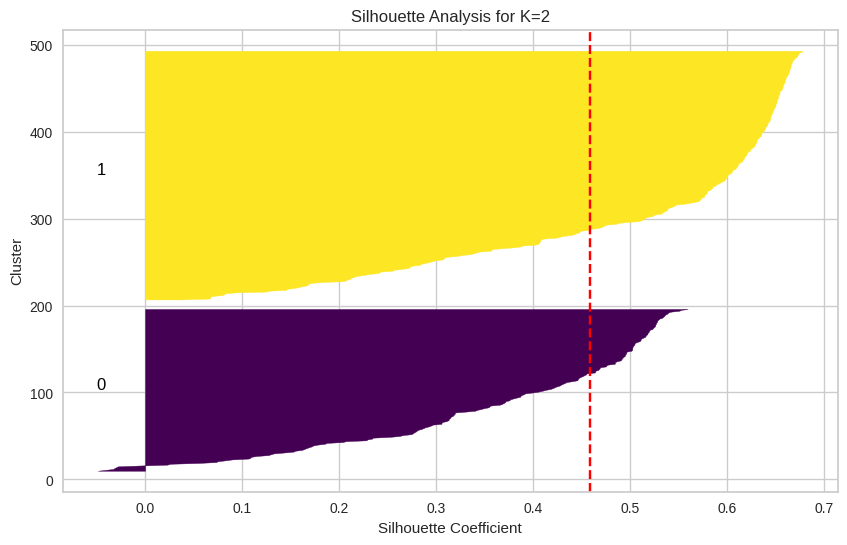

In [8]:
plot_silhouette(scaled_data, n_clusters=2)

It can be observed that in general it provides good results, only a few small points are shown with a worse positioning, being classified as belonging to cluster 0 (purple) when they are closer to the centroid of cluster 1.

#### **PCA with 2 components and k=4**
When applying the selection of the number of clusters we observed that grouping into 4 groups was a good alternative.

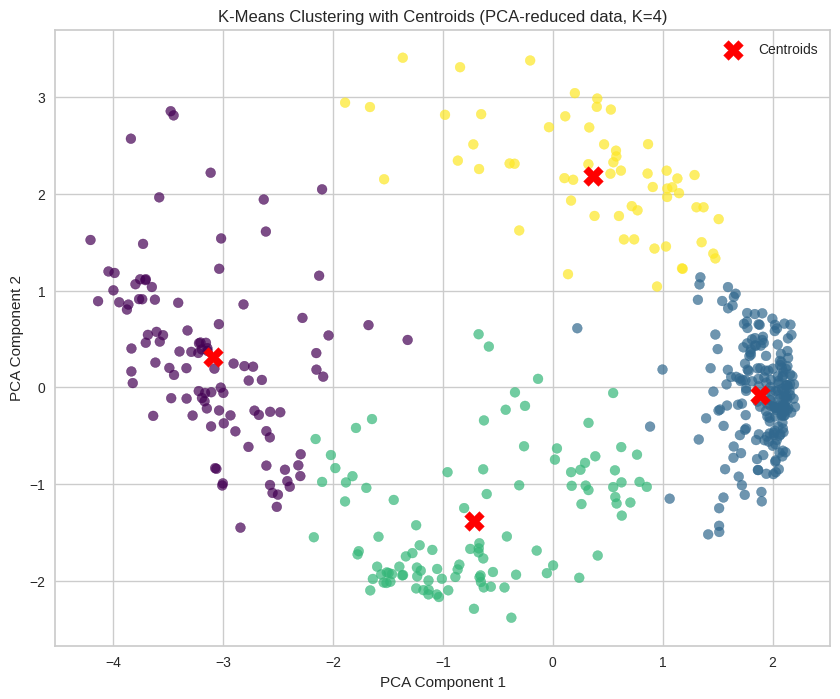

In [9]:
visualize_kmeans_with_pca(scaled_data, n_clusters=4)

Compared to the previous visualization with K=2, K=2 offers a simpler interpretation of the data. While K=4 identified finer-grained clusters, K=2 highlights the broader biological categories. To gain a deeper understanding of the underlying biological processes, it might be valuable to explore both configurations and analyze the characteristics of the genes within each cluster



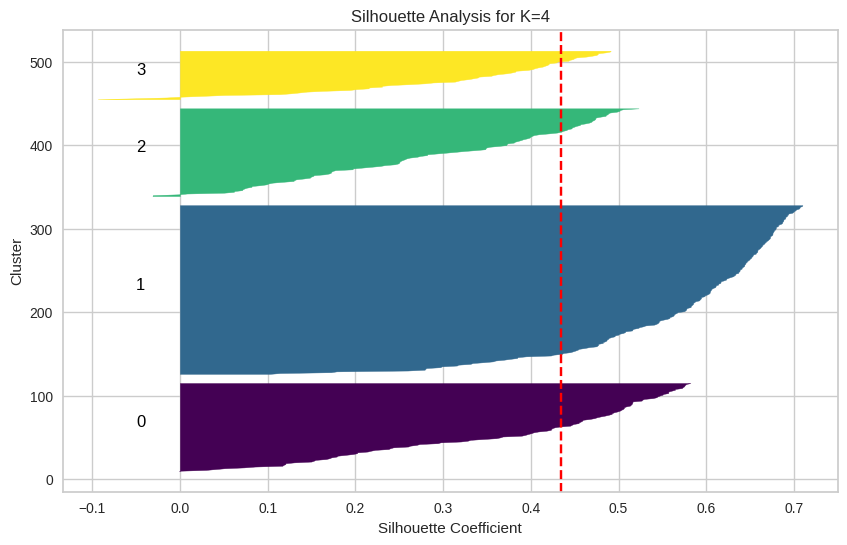

In [10]:
plot_silhouette(scaled_data, n_clusters=4)

#### **PCA with 3 components and k=4**
Although it is not highly recommended because it increases the complexity of understanding, it is also possible to use 3 components to graph it in a 3D space. By slightly modifying the previous function we can apply PCA seeking to obtain 3 components.

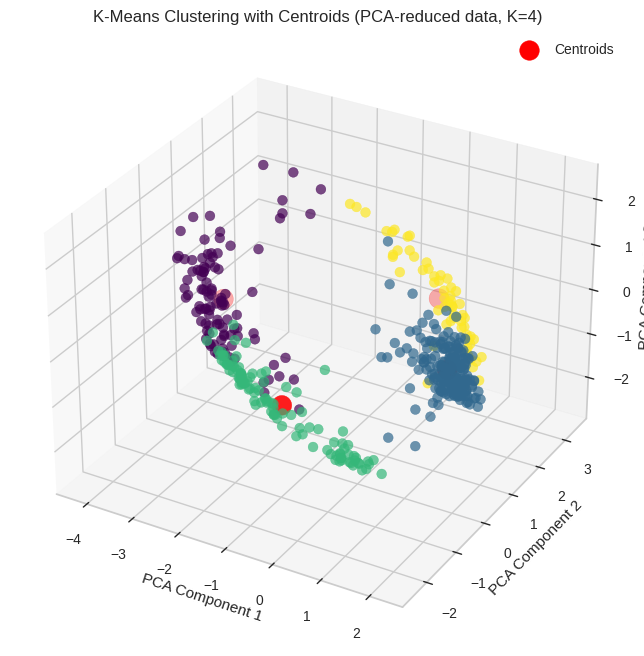

In [11]:
def visualize_kmeans_with_pca_3d(scaled_data, n_clusters=2):
    # Asegúrate de que scaled_data es un DataFrame
    if isinstance(scaled_data, pd.DataFrame):
        scaled_data = scaled_data.values  # Convertir a matriz NumPy

    # Reducción de dimensionalidad con PCA
    pca = PCA(n_components=3)
    pca_data = pca.fit_transform(scaled_data)

    # Aplicar KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=69)
    clusters = kmeans.fit_predict(scaled_data)

    # Crear un scatter plot 3D con los clusters
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c=clusters, cmap='viridis', s=50, alpha=0.7)

    # Añadir los centroides al gráfico
    centroids = kmeans.cluster_centers_
    centroids_pca = pca.transform(centroids)  # Transformar los centroides a las dimensiones de PCA
    ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], centroids_pca[:, 2], c='red', s=200, marker='o', label='Centroids')

    # Etiquetas y título
    ax.set_title(f'K-Means Clustering with Centroids (PCA-reduced data, K={n_clusters})')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.legend()
    plt.show()


visualize_kmeans_with_pca_3d(scaled_data, n_clusters=4)


It looks a bit like its 2D version, I think it's interesting to see but it doesn't deserve much attention. We will continue evaluating in 2 components.

### **Applying Hierarchical Clustering (HC)**
Hierarchical clustering is a method that groups data into a hierarchical structure, represented by a dendrogram. This approach can be agglomerative, starting with each point as an individual cluster and combining them, or divisive, starting with a single cluster and dividing it into smaller parts. The main advantage of hierarchical clustering is that it does not require specifying the number of clusters in advance, as the dendrogram allows the relationship between the data to be visualized. However, it can be computationally expensive, especially with large data sets.

In this method
1. **Scale** the data to normalize it.

2. **Apply Linkage Method,** The 'ward' method is used to calculate the distances between the data points and group them hierarchically.

3. **Create Dendrogram**, is generated that illustrates the hierarchical structure of the clusters, allowing the visualization of how the data is grouped. A horizontal line indicates the cutoff threshold.

4. **Define Clusters** From the dendrogram, clusters are established based on the specified cutoff threshold, allowing you to decide how many groups will be formed.

5. **Assign Clusters** A new column is added to the DataFrame containing the cluster assignments for each observation, facilitating further analysis.

6. **Show Results** A preview of the data, including the assigned clusters, is printed to verify the result of the clustering.

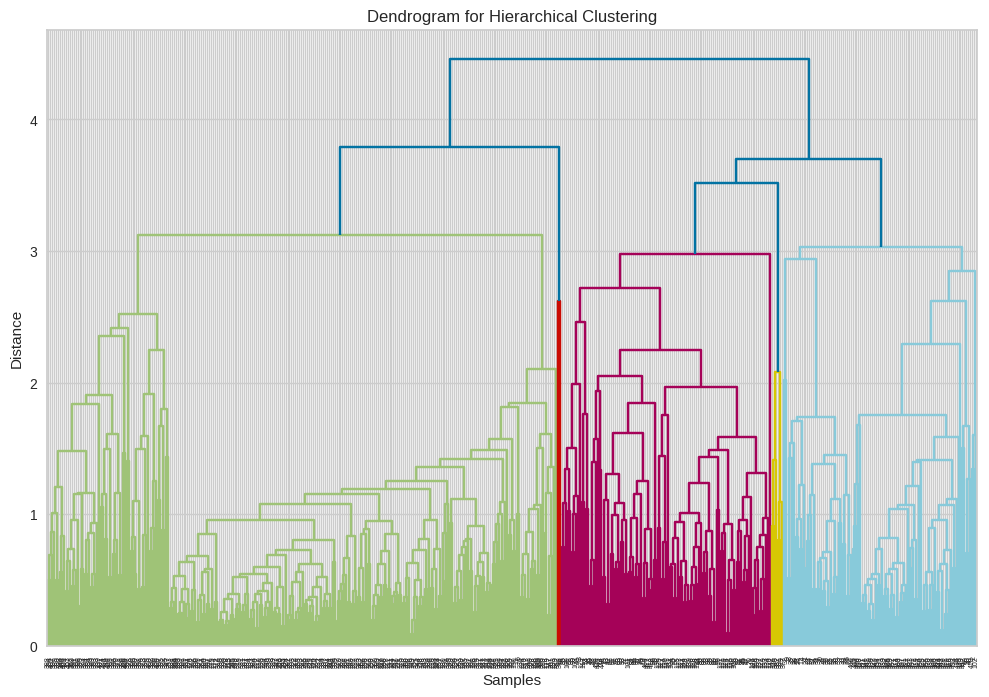

In [12]:


# Asegúrate de que 'scaled_data' es un DataFrame de pandas
scaled_data = pd.DataFrame(scaled_data)  # Si scaled_data no es un DataFrame

# Escalar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(scaled_data)

# Aplicar el método de enlace (linkage)
linked = linkage(scaled_data, method='average')  # Puedes elegir 'single', 'complete', 'average', 'ward'

# Crear el dendrograma
plt.figure(figsize=(12, 8))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.axhline(y=10, color='r', linestyle='--')  # Línea horizontal para indicar el corte de los clusters
plt.show()

# Crear clusters a partir del dendrograma
# Ajusta el valor de t según lo que visualices en el dendrograma
t = 4  # Este es el umbral de corte, ajústalo según tu dendrograma
clusters = fcluster(linked, t, criterion='distance')

# Añadir los clusters al DataFrame
scaled_data_df = pd.DataFrame(scaled_data)
scaled_data_df['Cluster'] = clusters


In [13]:
#metricas
# Calcular y mostrar el número de clústeres resultantes
num_clusters = len(np.unique(clusters))
print(f'Número de clústeres resultantes: {num_clusters}')

# Silhouette Score
hierarchical_silhouette = silhouette_score(scaled_data, clusters)
# Davies-Bouldin Index
db_hc = davies_bouldin_score(scaled_data, clusters)
# Calcular y mostrar el Calinski-Harabasz Index
calinski_harabasz_avg_hiera = calinski_harabasz_score(scaled_data, clusters)

# Función para calcular el V1 Score
def calculate_v1_score_hc(data, labels, t):
    num_clusters_original = len(np.unique(labels))
    num_data = data.shape[0]

    # Eliminar puntos temporales y recalcular los clústeres
    sum_proportion = 0
    for i in range(num_data):
        data_temp = np.delete(data, i, axis=0)

        # Recalcular el linkage y clústeres
        linked_temp = linkage(data_temp, method='average')
        clusters_temp = fcluster(linked_temp, t, criterion='distance')

        num_clusters_temp = len(np.unique(clusters_temp))

        # Calcular la proporción de cambio
        sum_proportion += abs(num_clusters_temp - num_clusters_original) / num_clusters_original

    v1_score = sum_proportion / num_data
    return v1_score

# Calcular V1 Score
v1_score_hc = calculate_v1_score_hc(scaled_data, clusters, t)



Número de clústeres resultantes: 2


The horizontal red line indicates a potential cutoff threshold for defining clusters. Based on the cutoff threshold, the data has been divided into 2 clusters. The "Cluster" column in the DataFrame shows the assigned cluster for each observation.

### **Self-organizing maps (SOM)**

Self-organizing maps (SOM) are a type of artificial neural network used for unsupervised learning. They project high-dimensional data into a lower-dimensional space (typically 2D), preserving the topological properties of the data. SOMs are particularly useful for clustering and visualizing complex data patterns, as they group similar input data together, making it easier to identify relationships and structures.

Explanation of the next code:
1. **Define SOM Size** (A grid size for the SOM is defined (in this case, a 5x5 grid)).

2. **Create SOM Object:** (Specifying the grid size and the number of features in the input data (scaled_data.shape[1]))

3. **Initialize the SOM:** (The weights of the SOM nodes are initialized randomly using the input data to provide a starting point for training.)

4. **Train the SOM**  (The SOM is trained with the train_random method over a specified number of iterations (100 in this case)).
5. **Get Node Coordinates** (the nodes that best match the input data, are obtained using the win_map method. This creates a mapping of input data to the nodes in the SOM.)

6. **Visualize Results:** The results are visualized by creating a heatmap of the distance map of the SOM, which represents the distances between nodes. Additionally, the number of data points associated with each node is displayed on the grid, providing insights into how many data points cluster around each node)

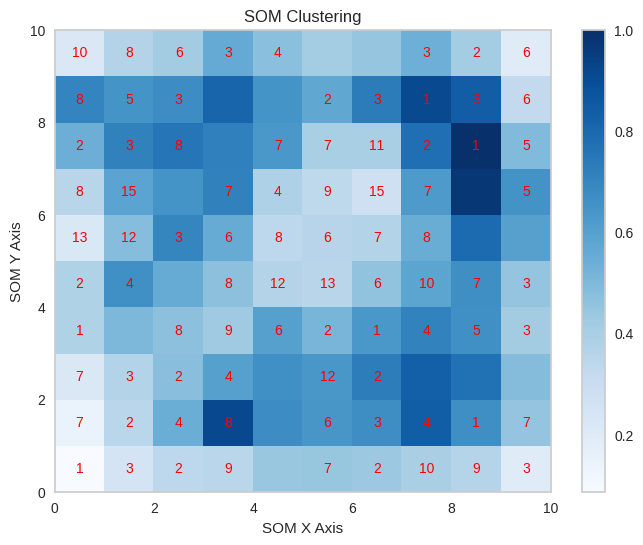

Número de clústeres basado en el mapa de distancias del SOM: 3


In [14]:
# Función para entrenar SOM y visualizar el mapa
def train_and_visualize_som(scaled_data, som_size=5, num_iterations=100):
    # Crear un objeto SOM
    som = MiniSom(som_size, som_size, scaled_data.shape[1], sigma=1.0, learning_rate=0.5)

    # Inicializar el mapa
    som.random_weights_init(scaled_data)

    # Entrenar el SOM
    som.train_random(scaled_data, num_iterations)

    # Obtener las coordenadas de los nodos del SOM
    win_map = som.win_map(scaled_data)

    # Contar el número de nodos "activos" (clústeres)
    num_clusters = sum(1 for key in win_map if win_map[key])

    # Visualizar el mapa de distancias
    plt.figure(figsize=(8, 6))
    plt.title('SOM Clustering')
    plt.pcolor(som.distance_map().T, cmap='Blues')  # Mapa de distancias
    plt.colorbar()

    # Añadir los puntos de datos en el mapa
    for x in range(som_size):
        for y in range(som_size):
            if win_map[(x, y)]:
                plt.text(x + 0.5, y + 0.5, str(len(win_map[(x, y)])),
                         ha='center', va='center', color='red', fontsize=10)

    plt.xlim(0, som_size)
    plt.ylim(0, som_size)
    plt.xlabel('SOM X Axis')
    plt.ylabel('SOM Y Axis')
    plt.show()

    return som, num_clusters


# Función para obtener las etiquetas de clustering del SOM (BMU para cada dato)
def get_som_labels(som, scaled_data, som_size):
      # Asignar cada dato a su Best Matching Unit (BMU)
    bmu_coordinates = np.array([som.winner(x) for x in scaled_data])

    # Convertir las coordenadas de los BMU a etiquetas de clúster únicas
    bmu_labels = np.array([x[0] * som_size + x[1] for x in bmu_coordinates])

    return bmu_labels


# Función para determinar el número de clústeres basado en el mapa de distancias
def cluster_som_by_distance_map(som, distance_threshold=0.5):
    # Obtener el mapa de distancias del SOM
    distance_map = som.distance_map()
    # Crear un mapa binario: 1 si la distancia es menor que el umbral, 0 si es mayor
    binary_distance_map = distance_map < distance_threshold
    # Usar la función de etiquetado para encontrar regiones conectadas (clústeres)
    labeled_array, num_clusters = label(binary_distance_map)
    return num_clusters


# Función para calcular el V1 Score
def calculate_v1_score(data, labels, som, som_size, distance_threshold=0.5):

    num_clusters_original = cluster_som_by_distance_map(som, distance_threshold)
    num_data = data.shape[0]

    # Eliminar puntos temporales y recalcular los clústeres
    sum_proportion = 0
    for i in range(num_data):
        data_temp = np.delete(data, i, axis=0)
        labels_temp = np.delete(labels, i)

        # Crear un nuevo SOM con el tamaño som_size
        som_temp = MiniSom(som_size, som_size, data.shape[1])
        som_temp.random_weights_init(data_temp)
        som_temp.train_random(data_temp, 100)  # Reentrenar con los datos eliminados
        num_clusters_temp = cluster_som_by_distance_map(som_temp, distance_threshold)

        sum_proportion += abs(num_clusters_temp - num_clusters_original) / num_clusters_original

    v1_score = sum_proportion / num_data
    return v1_score


# Escalar los datos (si no están escalados ya)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(scaled_data)  # Asegúrate de que scaled_data esté definido como un DataFrame o array

# Entrenar el SOM y visualizar los resultados
som_size = 10
som, som_clusters = train_and_visualize_som(scaled_data, som_size=som_size, num_iterations=1100)

# Obtener las etiquetas de clustering para los datos
som_labels = get_som_labels(som, scaled_data, som_size)

# Determinar el número de clústeres basado en el mapa de distancias
num_clusters_by_distance = cluster_som_by_distance_map(som, 0.2)
print(f"Número de clústeres basado en el mapa de distancias del SOM: {num_clusters_by_distance}")

# Calcular las métricas conocidas
silhouette_avg_SOM = silhouette_score(scaled_data, som_labels)
calinski_harabasz_avg_SOM = calinski_harabasz_score(scaled_data, som_labels)
davies_bouldin_avg_SOM = davies_bouldin_score(scaled_data, som_labels)
v1_score_SOM = calculate_v1_score(scaled_data, som_labels, som, som_size, distance_threshold=0.3)

### **Other Possible Implementations**

- **DIANA (Divisive Analysis Clustering)** Although it is very similar to Hierarchical Clustering, its main difference lies in the way the data is grouped. Diana is a divisive approach that starts with all the data in a single cluster and divides it, while Hierarchical Clustering is an agglomerative approach that starts with each point as an individual cluster and combines them.
- **Fanny:** This method uses fuzzy logic and produces
a probability vector for each observation. A hard cluster
is determined by assigning an observation to a group
which has the highest probability. Like distance-based
methods, one has a choice of using a general dissimilarity
measure. We have used the L1 distance (also known
as Manhattan distance) which is more robust than the
Euclidean distance.
- **Model-based clustering**: The idea behind model
based clustering is to regard the data as coming from
a mixture distribution.
- **Hierarchical clustering with partial least squares:** The usefulness of partial least squares in identifying gene
relationships through their expression profiles has recently
been demonstrated by Datta (2001)


More information:
[Susmita Datta, Somnath Datta, Comparisons and validation of statistical clustering techniques for microarray gene expression data, Bioinformatics, Volume 19, Issue 4, March 2003, Pages 459–466, ](https://doi.org/10.1093/bioinformatics/btg025 )



### **Validation**

When choosing which value of k to apply kmeans, we saw some very useful metrics incorporated in the sklearn package, such as a more manual metric based on scientific papers. I consider that they can serve as a validation reference to compare how well each method grouped.

In [15]:
# Definir las métricas para K-Means
k = 2

kmeans_metrics_k2 = {
    "Metric": ["Silhouette Score", "Calinski-Harabasz Index", "Davies-Bouldin Index", "V1 Score"],
    "K-Means (K=2)": [
        metrics_kmers[k]['Silhouette Score'],
        metrics_kmers[k]['Calinski-Harabasz Index'],
        metrics_kmers[k]['Davies-Bouldin Index'],
        metrics_kmers[k]['V1 Score']  # Añadir la métrica V1
    ]
}

# Definir las métricas para Hierarchical
hierarchical_metrics = {
    "Metric": ["Silhouette Score", "Calinski-Harabasz Index", "Davies-Bouldin Index", "V1 Score"],
    "Hierarchical": [
        hierarchical_silhouette,
        calinski_harabasz_avg_hiera,
        db_hc,
        v1_score_hc  # Añadir la métrica V1, si está disponible
    ]
}

# Definir las métricas para SOM
som_metrics = {
    "Metric": ["Silhouette Score", "Calinski-Harabasz Index", "Davies-Bouldin Index", "V1 Score"],
    "SOM": [
        silhouette_avg_SOM,
        calinski_harabasz_avg_SOM,
        davies_bouldin_avg_SOM,
        v1_score_SOM  # Añadir la métrica V1, si está disponible
    ]
}

# Crear DataFrames
df_kmeans = pd.DataFrame(kmeans_metrics_k2)
df_hierarchical = pd.DataFrame(hierarchical_metrics)
df_som = pd.DataFrame(som_metrics)

# Unir los DataFrames
comparison_df = df_kmeans.merge(df_hierarchical, on="Metric", how="outer").merge(df_som, on="Metric", how="outer")

# Mostrar la tabla de comparación
print(comparison_df)


                    Metric  K-Means (K=2)  Hierarchical        SOM
0  Calinski-Harabasz Index     449.800216    398.348592  83.780514
1     Davies-Bouldin Index       0.942311      1.002094   1.157499
2         Silhouette Score       0.459052      0.439017   0.134569
3                 V1 Score       0.035564      0.013713   0.242616


Overall, K-Means with **𝐾 = 2** excels in all the metrics analyzed, suggesting that it is the most suitable clustering method for this dataset. Hierarchical clustering shows intermediate performance, while self-organizing maps present the lowest performance in terms of cluster separation and cohesion. This could indicate that although SOM is useful for certain types of data and visualizations, in this specific case it fails to offer the same clustering quality as K-Means or the hierarchical method.